In [1]:
import pyspark
import math
import pandas as pd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import time


In [2]:
def conta_palavras(item):
    url, conteudo = item
    palavras = conteudo.strip().split()
    return [(palavra.lower(), 1) for palavra in set(palavras)]

def junta_contagens(nova_contagem, contagem_atual):
    return nova_contagem + contagem_atual

def computa_relevancia(item):
    palavra, contagem = item
    return (palavra, math.log10(1 + contagem))

def cria_data_frame(data = []):
    palavras = [item[0] for item in data]
    relevancias = [item[1] for item in data]
        
    dataFrameData = {
        'PALAVRA': palavras,
        'RELEVANCIA': relevancias
    }
    
    df = pd.DataFrame(data=dataFrameData, columns=['PALAVRA', 'RELEVANCIA'])
    pd.set_option('display.max_rows', df.shape[0]+1)
    return df


def read_stopwords(fileName):
    stopwords = set(STOPWORDS)

    stopwords_pt = []
    with open(fileName, "r") as file:
        for line in file.readlines():
            stopwords_pt.append(line.strip().replace('\n', ''))
    stopwords.update(stopwords_pt)

    return stopwords

def save_word_cloud(word_cloud, fileName):
    word_cloud.to_file(fileName)
    
def plot_word_cloud(word_cloud):
    fig, ax = plt.subplots(figsize=(16,8))
    ax.imshow(word_cloud, interpolation='bilinear')
    ax.set_axis_off()
    plt.imshow(word_cloud)

def create_word_cloud(data, fileName, stopwords, size = (1600, 800), background_color = 'black'):
    words = ' '.join(data)
    width, height = size
    word_cloud = WordCloud(
        stopwords=stopwords,
        background_color=background_color,
        width=width,
        height=height
    ).generate(words)
    
    save_word_cloud(word_cloud, fileName)
    plot_word_cloud(word_cloud)
    
    return word_cloud


In [3]:
sc = pyspark.SparkContext(appName="CalculaRelevancia")
sc

<SparkContext master=local[*] appName=CalculaRelevancia>

In [4]:
rdd =  sc \
        .sequenceFile('part-00000').repartition(sc.defaultParallelism)

In [5]:
palavra1 = 'intel'
palavra2 = 'amd'
stopwords = read_stopwords('stopwords_pt.txt')

In [6]:
# Filtra por paginas que possuem a palavra1 e não possuem a palavra2
def filtra_palavra1(item):
    url, conteudo = item
    conteudo = conteudo.strip().split()
    return palavra1 in conteudo and palavra2 not in conteudo

# Filtra por paginas que possuem a palavra2 e não possuem a palavra1
def filtra_palavra2(item):
    url, conteudo = item
    conteudo = conteudo.strip().split()
    return palavra2 in conteudo and palavra1 not in conteudo

# Filtra por paginas que possuem a palavra1 e a palavra2
def filtra_palavras_juntas(item):
    url, conteudo = item
    conteudo = conteudo.strip().split()
    return palavra1 in conteudo and palavra2 in conteudo

In [7]:
rdd_palavra1 = rdd.filter(filtra_palavra1)
rdd_palavra2 = rdd.filter(filtra_palavra2)
rdd_palavras = rdd.filter(filtra_palavras_juntas)

In [8]:
DOC_COUNT_MIN = 3
DOC_COUNT_MAX = 0.7
N = rdd.count()
def palavras_mais_relevantes(_rdd, n):
    tempo_inicial = time.time()
    
    # Função para remover palavras muico comuns como 'a', 'o', 'seus', etc...
    def _filtra_stopword(palavra):
        return (len(palavra) and palavra.isalpha() and (palavra not in stopwords))

    # Função para remover palavras com contagem menor que 5 e menor que 70% do numero total de paginas
    def _filtra_contagem(contagem):
        return (contagem >= DOC_COUNT_MIN and (contagem < DOC_COUNT_MAX * N))
    
    # Função para agregar os filtros relacionados ao item
    def filtra_item(item):
        palavra, contagem = item
        return (_filtra_stopword(palavra) and _filtra_contagem(contagem))
    

    # Conta quantas vezes cada palavra aparece agr o item passa a ser (palavra, contagem)
    rdd_contagens = _rdd.flatMap(conta_palavras).reduceByKey(junta_contagens)

    # Faz a filtragem dos itens pela contagem e pela lista de palavras proibidas (stopwords)
    rdd_contagens_filtrado = rdd_contagens.filter(filtra_item)
    
    # Calcula a Relevância da palavra usando a contagem
    rdd_relevancia = rdd_contagens_filtrado.map(computa_relevancia)
    
    # Funções para ordernar os n primeiros items em ordem decrescente
    ordena_freq = lambda item: -item[1]
    top_n = rdd_relevancia.takeOrdered(n, ordena_freq)
    
    tempo_final = time.time()
    
    print(f'Tempo: {tempo_final-tempo_inicial}')
    return top_n



top100_palavra1 = palavras_mais_relevantes(rdd_palavra1, 100)
top100_palavra2 = palavras_mais_relevantes(rdd_palavra2, 100)
top100_palavras = palavras_mais_relevantes(rdd_palavras, 100)

Tempo: 2.84975266456604
Tempo: 2.790644407272339
Tempo: 2.621866226196289


In [9]:
palavra1_df = cria_data_frame(top100_palavra1)
palavra2_df = cria_data_frame(top100_palavra2)
palavras_df = cria_data_frame(top100_palavras)

## Relevância de palavras para as paginas que contem a palavra1

In [10]:
palavra1_df

,PALAVRA,RELEVANCIA
0,todos,1.716003
1,intel,1.672098
2,desconto,1.591065
3,internet,1.568202
4,conteúdo,1.544068
...,...,...
95,ibm,1.204120
96,amazon,1.204120
97,experience,1.204120
98,blue,1.204120


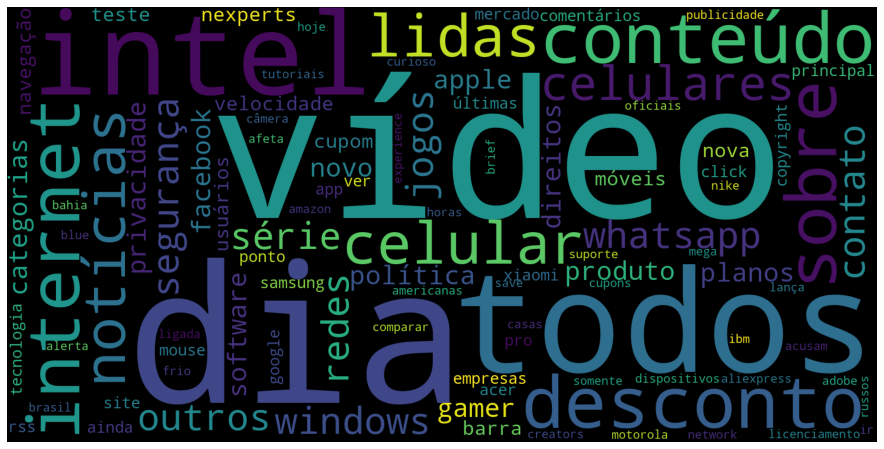

In [11]:
create_word_cloud(palavra1_df['PALAVRA'], 'palavra1.png', stopwords)

## Relevância de palavras para as paginas que contem a palavra2

In [12]:
palavra2_df

,PALAVRA,RELEVANCIA
0,novo,1.000000
1,ano,0.954243
2,youtube,0.954243
3,us,0.954243
4,artigos,0.954243
...,...,...
95,melo,0.778151
96,ribeiro,0.778151
97,edição,0.778151
98,nunca,0.778151


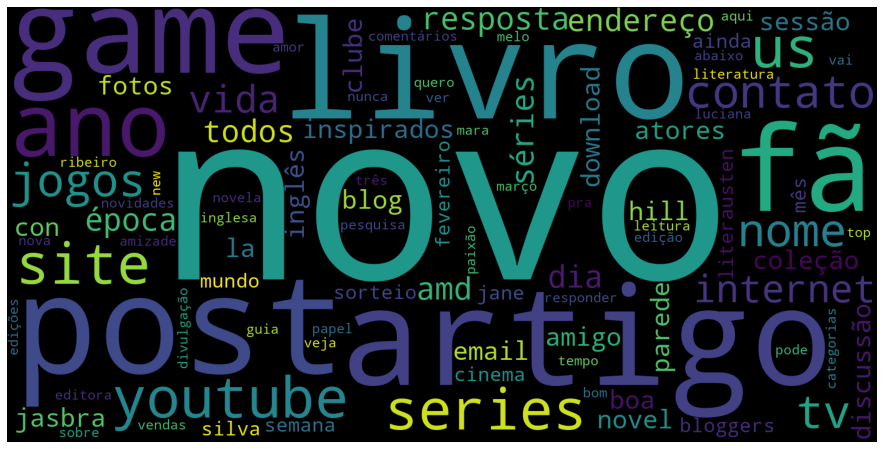

In [13]:
create_word_cloud(palavra2_df['PALAVRA'], 'palavra2.png', stopwords)

## Relevância de palavras para as paginas que contem a palavra1 e a palavra2

In [14]:
palavras_df

,PALAVRA,RELEVANCIA
0,dell,0.778151
1,todos,0.778151
2,iphone,0.778151
3,samsung,0.778151
4,smartphone,0.698970
5,hd,0.698970
6,whatsapp,0.698970
7,motorola,0.698970
8,jogos,0.698970
9,ram,0.698970


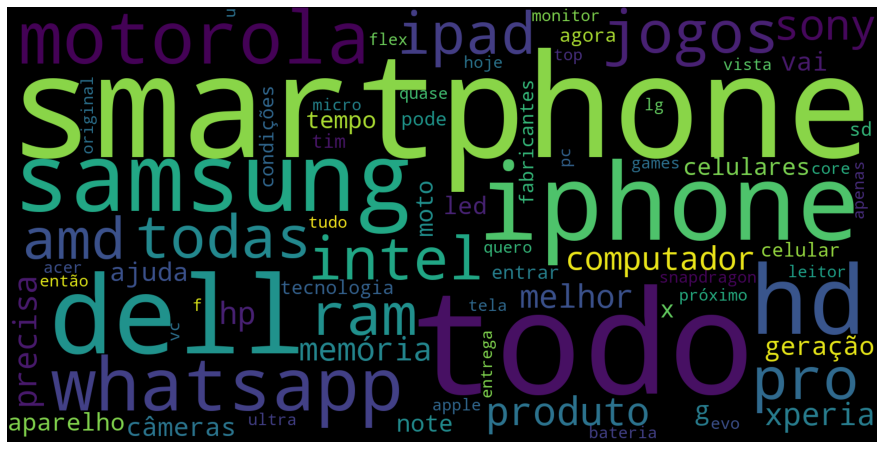

In [15]:
create_word_cloud(palavras_df['PALAVRA'], 'palavras.png', stopwords)

In [16]:
sc.stop()